In [3]:
import numpy as np
import scipy
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua.utils.controlled_circuit import get_controlled_circuit
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

/home/tinyrick/anaconda3/envs/qcomp/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


## Some more imports  

In [4]:
import qiskit

In [5]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import QFT
from qiskit.quantum_info import random_statevector
from qiskit.opflow import X,Y,Z,I,CX
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

In [6]:
from qiskit.algorithms import NumPyEigensolver
from qiskit.aqua.operators import WeightedPauliOperator, MatrixOperator, op_converter

## QPE : Defining matrix to control gate convertor, Quantum Phase Estimator and result.count to eigen value convertor

In [9]:
#Operator to gate convertor
def qc(operator):
    qubit_list = list(range(int(np.log(len(operator))/np.log(2))))
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    #gate = qc.to_gate().control(1)
    return qc

In [10]:
#s_qubits is number available of energy levels
def evoloperator(s_qubits):
    evoloperator2 = QuantumCircuit(s_qubits)
    for p in range(s_qubits):
        for q in range(s_qubits):
            if (q > p):
                evoloperator2 = evoloperator2.compose(qc(operator),[p,q])
    evol_gate = evoloperator2#.to_gate().control(1)
    return evol_gate

In [11]:
# my_qpe takes in work qubits, simulation qubits, initialization condition and number of repetitions gate and applies QFT inverse
# Please convert/make sure the initial_state to a list before passing in argugement
def my_qpe(w_qubits,s_qubits, gate, initial_state = None, repetitions=1):  
    qpe_0 = QuantumCircuit(w_qubits+s_qubits,w_qubits)
    if (initial_state != None):
        qpe_0.initialize(initial_state,list(range(w_qubits,w_qubits+s_qubits)))
    for i in range(w_qubits):
        qpe_0.h(i)
    for j in range(trotter_number):
        for counting_qubit in range(w_qubits):
            for i in range(repetitions):
                qubit_list = [counting_qubit]+list(range(w_qubits,w_qubits+s_qubits))
                qpe_0.append(gate,qubit_list)
            repetitions *= 2
        repetitions = 1
    qpe_1 = QFT(w_qubits, 0, True , True)
    l = [*range(w_qubits)]
    qpe = qpe_0.compose(qpe_1, l)
    qpe.measure(l,l)
    return qpe

In [9]:
#Eigen values of Hamiltonian operator H, n is to choose how many data points from the plot are we selecting
def plot_to_eigenval(count,w_qubits,n):
    list_ = []
    if t == 0:
        display(0)
    else:
        lists = sorted(count, key=count.get, reverse=True)[:n]
        #k=Counter(count).most_common(w_qubits) # Method to pick out the most probable outcomes based on number of expected eigen values
        for j in range(len(lists)):
            #temp = str(lists[j])
            #temp = temp[::-1]
            lists[j] =  int(str(lists[j]), 2)
            #lists[j] =  int(temp, 2) #Convert them to decimal values
        for j in range(len(lists)):
            list_.append((2*pi*(2**w_qubits - lists[j]))/((2**w_qubits)*t))
            lists[j] = -2*pi*(lists[j])/((2**w_qubits)*t)
        return lists,list_

In [10]:
simulator = Aer.get_backend('qasm_simulator')

## Testing something out

In [10]:
import matplotlib.pyplot as plt

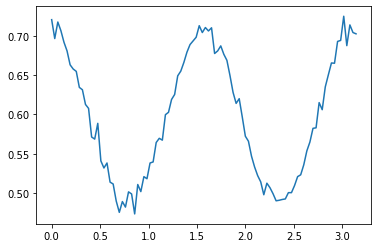

In [32]:
prob_1 = []
theta_ = []
for theta in np.linspace(0,pi,100):
    H = (-cos(theta) *  X) + \
        (-sin(theta) * I)
    Hn = H.exp_i()
    hamiltonian = Hn.to_matrix()
    gate = qc(hamiltonian).to_gate().control(1)
    inv_gate = qc(hamiltonian).inverse().to_gate().control(1)
    lcu = QuantumCircuit(2,1)
    lcu.h(0)
    lcu.append(gate,[0,1])
    lcu.x(0)
    lcu.append(inv_gate,[0,1])
    lcu.h(0)
    lcu.measure([0],[0])
    result = execute(lcu, backend = simulator, shots = 3000).result()
    count = result.get_counts(lcu)
    prob_1.append(count['1']/3000)
    theta_.append(theta)
plt.plot(theta_,prob_1)


In [38]:
from sympy import symbols

In [42]:
theta = symbols('theta')
#W = [[sin(theta),cos(theta)],[cos(theta),sin(theta)]]


0.9092974268256817

In [34]:
count['1']/3000

0.7023333333333334

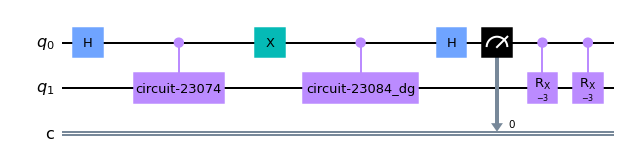

In [53]:
from qiskit.circuit.library import RXGate
gate = RXGate(3).inverse().control(1)
lcu.append(gate,[0,1])
lcu.draw('mpl')

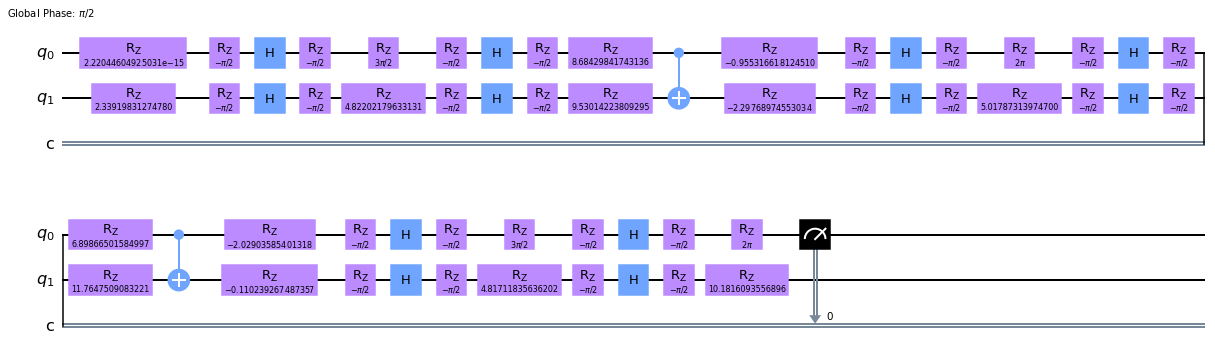

In [18]:
transpiled = transpile(lcu, basis_gates = ['h','cx','rz'],optimization_level = 3)
transpiled.draw('mpl')

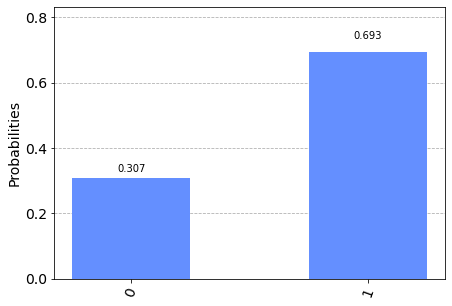

In [9]:
## Fake backends
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeCasablanca, FakeGuadalupe
sim_casa = AerSimulator.from_backend(FakeCasablanca())
sim_guad = AerSimulator.from_backend(FakeGuadalupe())

In [9]:
#import time
IBMQ.save_account('11b096c949c02da2b6b749443da414f34a8bb7cf7f6dc036488e57267a55f9e7ca9b5415425e719a84a07740a91ffb59b4126b22315012f8d415de3bd156a47f',overwrite = True)
provider = IBMQ.load_account()
real = provider.get_backend('ibmq_qasm_simulator')

## Test 1 : Ising Dimer Hamiltonian(Ref : "Optimizing quantum phase estimation for the simulation of Hamiltonian eigenstates")

In [2]:
trotter_number = 3
s_qubits = 2
w_qubits = 5

In [ ]:
#Same hamiltonian but defined differently for different algorithms
from qiskit.aqua.operators import WeightedPauliOperator
'''
pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": 0.33}, "label": "ZI"},
                   {"coeff": {"imag": 0.0, "real": 3.24}, "label": "IZ"},
                   {"coeff": {"imag": 0.0, "real": 1.17}, "label": "ZZ"}
                   ]
}
hamiltonian1 = WeightedPauliOperator.from_dict(pauli_dict)
hamiltonian3 = {"ZI" : 0.33, "IZ" : 3.24, "ZZ" : 1.17}
'''
H2_op = (0.33/trotter_number *  Z ^ I) + \
        (3.24/trotter_number * I ^ Z) + \
        (1.17/trotter_number * Z ^ Z)
H2 = H2_op.exp_i()
hamiltonian2 = H2.to_matrix()

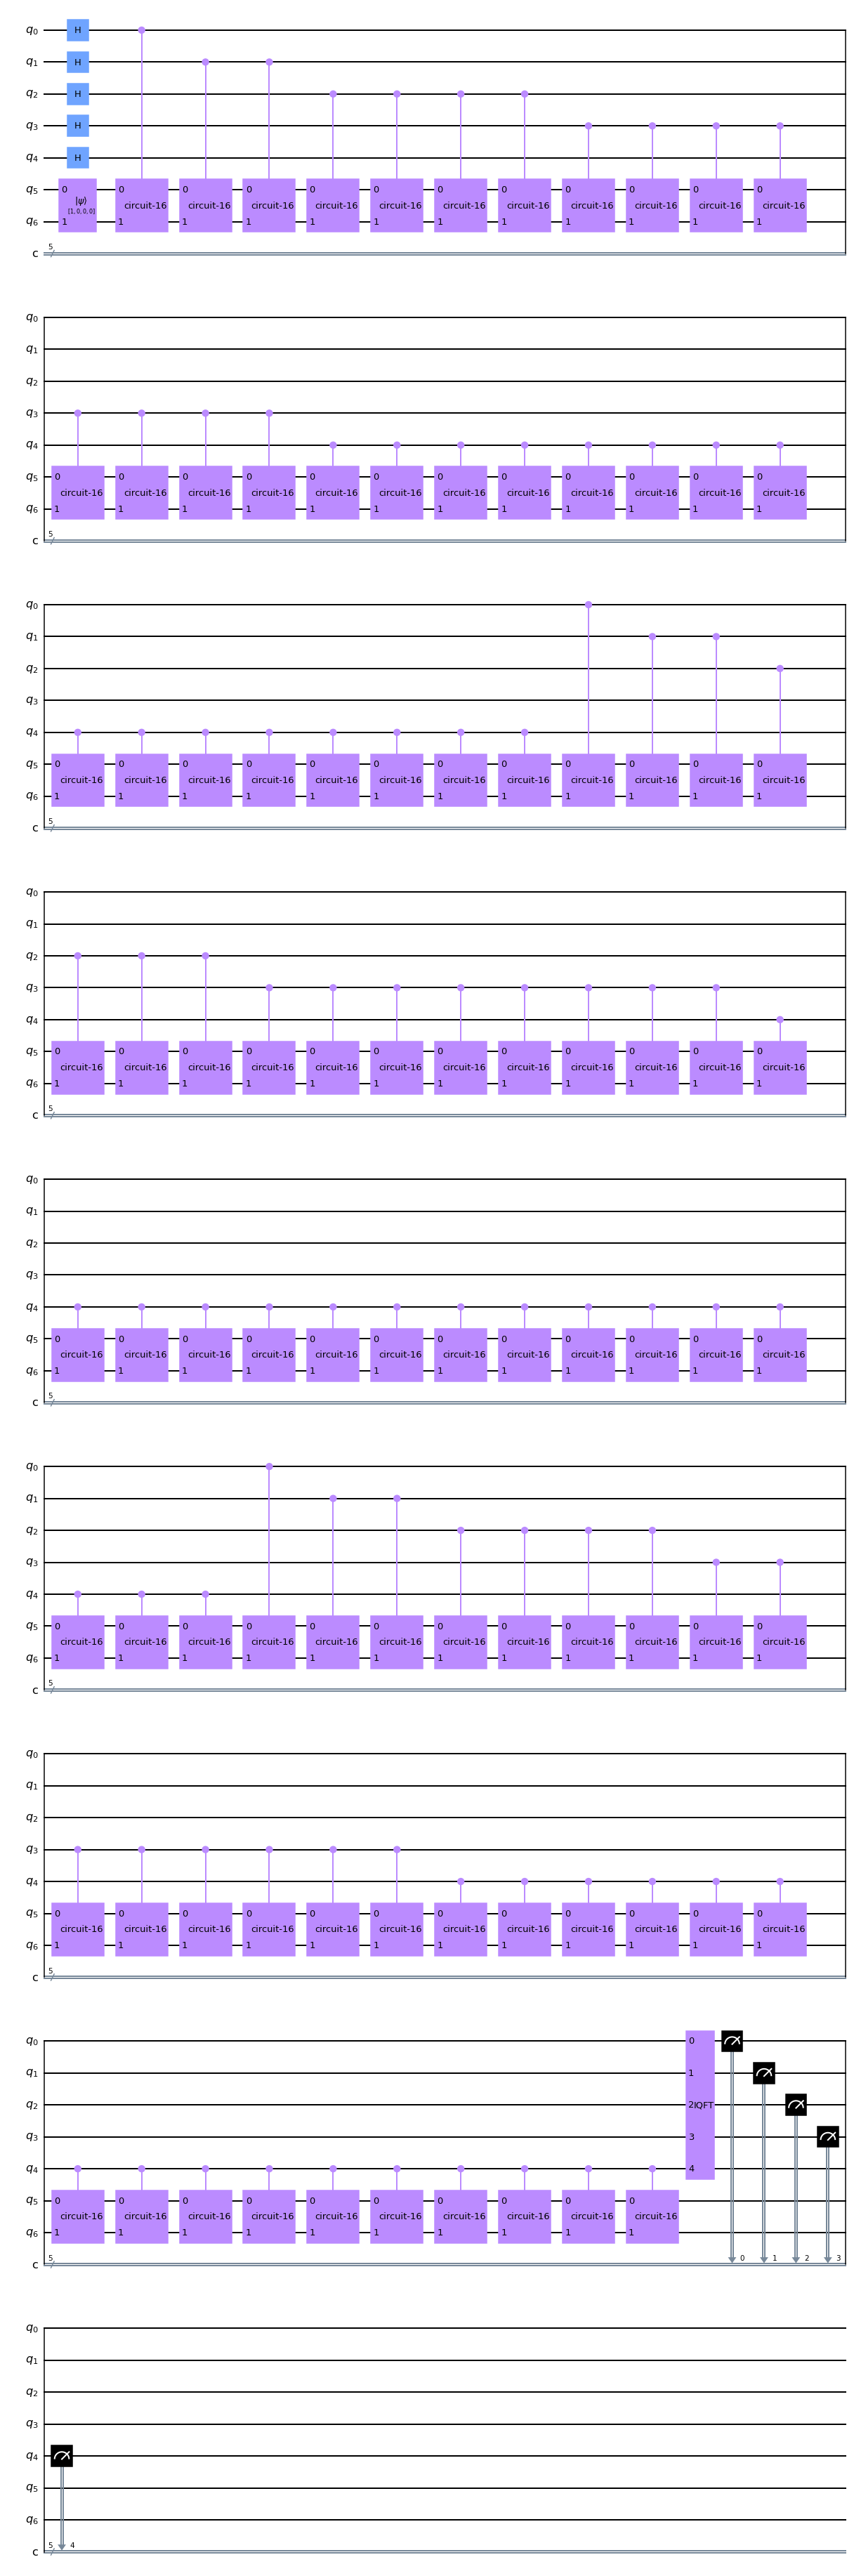

In [ ]:
#QPE 2 : My QPE
gate = qc(hamiltonian2).to_gate().control(1)
initial_state2 = [1,0,0,0]
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
result = execute(qpe2, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe2)
display(plot_histogram(count))

In [102]:
plot_to_eigenval(count,w_qubits,1)

([-1.5707963267948966], [4.71238898038469])

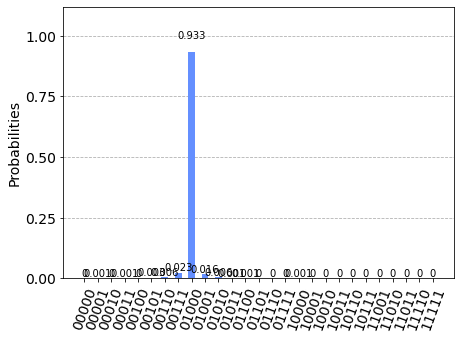

In [140]:
# same H2 and my_qpe but with a circuit this time 
def H2cir():
    evol = QuantumCircuit(2)
    evol.cx(0,1)
    evol.rz(2*1.17/trotter_number,1)
    evol.cx(0,1)
    evol.rz(2*3.24/trotter_number,1)
    evol.rz(2*0.33/trotter_number,0)
    return evol
ggate = H2cir().to_gate().control(1)
initial_state2 = [1,0,0,0]
qpe2 = my_qpe(w_qubits,s_qubits, ggate, initial_state = initial_state2)
result = execute(qpe2, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe2)
display(plot_histogram(count))


## Results for Ising Dimer : 

 $$ H_I = \omega_1 Z_1 + \omega_2 Z_2 + \omega_J Z_2 Z_2 $$ 

Given in paper 'Optimizing quantum phase estimation for the simulation of Hamiltonian eigenstates'
Here, $w\_qubits = 5$, $trotter\_number = 2$, method = direct matrix to evolution


| Intial State | Eigenvalue(Direct Method) | Eigenvalue(Indirect Method) | Exact Eigenvalue |  
| --- | --- | --- | --- |
| [1,0,0,0] | -1.57 | 4.712 | 4.74 |
| [0,1,0,0] | -4.12 | 2.159 | -4.08 |
| [0,0,1,0] | -5.10 | 1.7617 | 1.74 |
| [0,0,0,1] | -2.356 | 3.926 | -2.40 |

## Conclusion from above result
- for negative values of energy, use the direct method of, Eigen value, E = $-\frac{2\pi}{t*2^{w\_qubits}}\theta$, where $\theta $ is decimal of observed max count.
- for positive values of energy, use inderect method of , $\theta = 2^{w\_qubits}-\theta$
- the method of using circuit for evolution has same effect as direct method : 'H2 = H2_op.exp_i()->hamiltonian2 = H2.to_matrix()' $but the states \textbf{[0,1,0,0],[0,0,1,0]} $ got interchanged. $\textbf{Find out why}$
- notice that there is a minimum limit of $w\_qubits$ and $trotter\_number$ to get correct answers.


## Deuteron hamiltonian (Jordan weigner tranformation and potential(EFT) term $V_0 = −5.68658111 MeV$).

In [11]:
#2 body part
s_qubits = 2
w_qubits = 7
trotter_number = 1
H2_op = (5.906709/trotter_number * I ^ I) + \
        (0.218291/trotter_number * Z ^ I) - \
        (6.125/trotter_number * I ^ Z) - \
        (2.143304/trotter_number * X ^ X) - \
        (2.143304/trotter_number * Y ^ Y)
H2 = H2_op.exp_i()
hamiltonian2 = H2_op.to_matrix()

In [12]:
hamiltonian2

array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.48168973-0.68309484j,
        -0.20182265+0.51051353j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.20182265+0.51051353j,
        -0.11562162+0.8278135j ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.72967307+0.68379618j]])

In [14]:
e,v = np.linalg.eig(H2_op.to_matrix())
v = np.transpose(v)
e,v

(array([-1.74916122+0.j, 13.56257922+0.j,  0.        +0.j, 11.813418  +0.j]),
 array([[-0.        -0.j,  0.29278612-0.j,  0.95617796+0.j,
         -0.        -0.j],
        [ 0.        +0.j,  0.95617796+0.j, -0.29278612+0.j,
          0.        +0.j],
        [ 1.        +0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          1.        +0.j]]))

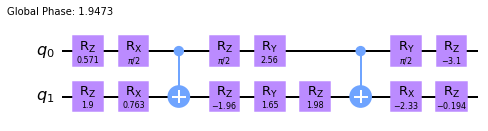

In [23]:
trans2 = transpile(qc(hamiltonian2),basis_gates = ['x','y','z','h','rx','ry','rz','t','cx','cz'])
trans2.draw('mpl')

In [27]:
trans2.to_gate().decompose().draw('mpl')

AttributeError: 'Gate' object has no attribute 'decompose'

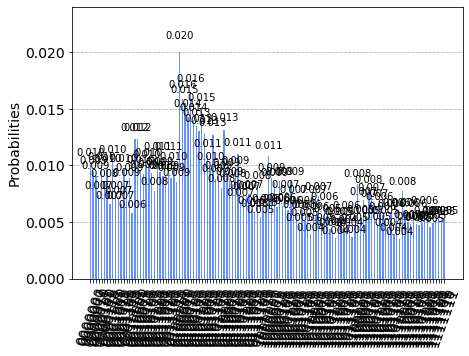

In [96]:
gate = qc(hamiltonian2).to_gate().control(1)
initial_state2 = list(v[0])
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
result = execute(qpe2, backend = sim_guad, shots = 10000,optimization_level = 3).result()
count = result.get_counts(qpe2)
plot_histogram(count)

In [ ]:
t =1
plot_to_eigenval(count,w_qubits,1)

([-1.5707963267948966], [4.71238898038469])

In [ ]:
trans_qpe = transpile(qpe2,basis_gates = ['cx','h','rz','rx','x','y'])
scale_factors = [1, 1.5, 2.,2.5,3.]
res = ZNErec(trans_qpe,7,scale_factors)

In [ ]:
plot_to_eigenval(res,w_qubits,1)

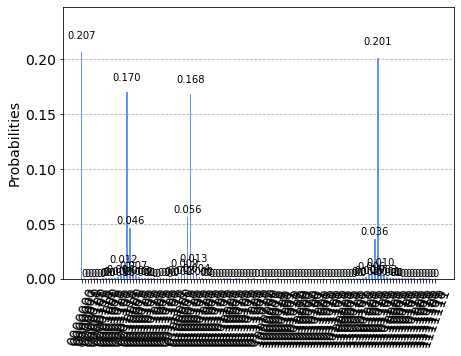

In [19]:
#with random states
gate = qc(hamiltonian2).to_gate().control(1)
tcount = {}
for i in range(10):#for 10 random statevectors
    initial_state2 = random_statevector(4)
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = simulator, shots = 3000).result()
    count = result.get_counts(qpe2)
    tcount = Counter(tcount)+Counter(count)
display(plot_histogram(tcount))

In [31]:
int('110',2)

6

In [47]:
ccount={}
for key in tcount:
    keys = int(key,2)/(2**w_qubits)
    if tcount[key]<20:
        pass
    else:
        ccount[keys] = tcount[key]

In [59]:
import matplotlib.pyplot as plt

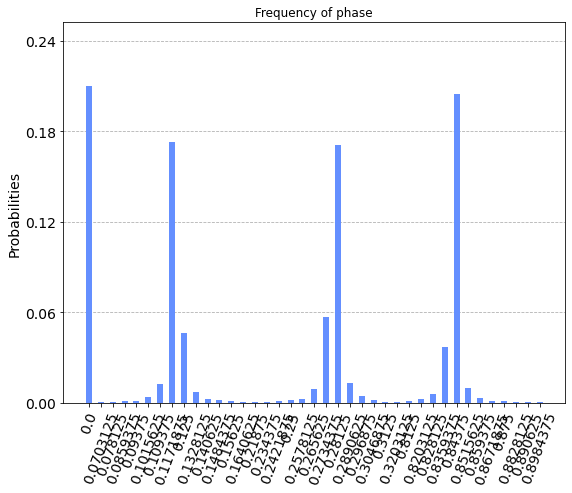

In [66]:
plot_histogram(ccount,figsize = (9,7),title = 'Frequency of phase',bar_labels = False)

In [ ]:
#with eigenstate
initial_state2 = list(v[0])

for trotter_number in range(1,7):
    
    gate = qc(hamiltonian2).to_gate().control(1)
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = real, shots = 10000).result()
    count = result.get_counts(qpe2)
    print(plot_to_eigenval(count,w_qubits,1))
    display(qpe2.depth())
    print(trotter_number)

NameError: name 'v' is not defined

In [2]:
print(f'Reference value for 2 qubits hamiltonian: -1.74916')

Reference value for 2 qubits hamiltonian: -1.74916


In [15]:
t = 1
plot_to_eigenval(count,w_qubits,1) #inorder to get correct value of -1.74 we need at least 10 control bits

([-3.141592653589793], [3.141592653589793])

In [28]:
print(time_taken)

246.263281583786


In [11]:
from collections import Counter

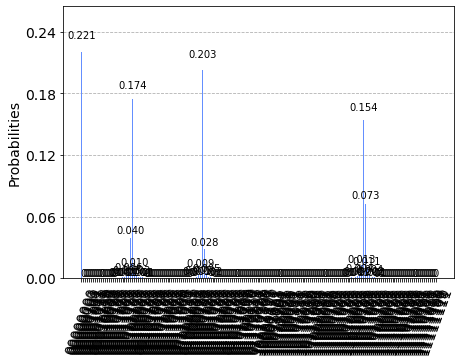

In [17]:
#with random states
gate = qc(hamiltonian2).to_gate().control(1)
tcount = {}
for i in range(10):#for 10 random statevectors
    initial_state2 = random_statevector(4)
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = simulator, shots = 3000).result()
    count = result.get_counts(qpe2)
    tcount = Counter(tcount)+Counter(count)
display(plot_histogram(tcount))

In [67]:
tcount

Counter({'1100000': 6,
         '1110011': 22,
         '0101100': 7,
         '1011010': 6,
         '0010100': 31,
         '0011000': 13,
         '0111000': 2,
         '1001010': 3,
         '0101101': 12,
         '0101110': 7,
         '1110101': 9,
         '1000001': 3,
         '0001001': 22,
         '0011110': 27,
         '0101010': 18,
         '0011010': 18,
         '0100111': 56,
         '0011011': 14,
         '1100010': 6,
         '1011111': 7,
         '1010001': 4,
         '0111100': 3,
         '1111011': 5,
         '1110111': 4,
         '1010101': 3,
         '0001010': 26,
         '1001110': 1,
         '0100110': 131,
         '0001100': 46,
         '0010000': 1377,
         '1100110': 17,
         '0010101': 25,
         '0101111': 4,
         '1101001': 86,
         '1111100': 6,
         '0101001': 21,
         '1101011': 1091,
         '0100010': 272,
         '0010010': 85,
         '0001111': 5096,
         '0100100': 5044,
         '0000011': 8,
 

In [20]:
t =1
plot_to_eigenval(tcount,w_qubits,4)

([-0.0, -1.7426021750380885, -0.760854470791278, -5.2768939103266055],
 [6.283185307179586, 4.540583132141498, 5.522330836388308, 1.0062913968529805])

### N=3 JWT EFT potential

In [68]:
#3body part
trotter_number = 3
wqubits = 10
s_qubits = 3
H3_op = (5.906709/trotter_number * I ^ I ^ I) + \
        (0.218291/trotter_number * Z ^ I ^ I) - \
        (6.125/trotter_number * I ^ Z ^ I) - \
        (2.143304/trotter_number * X ^ X ^ I) - \
        (2.143304/trotter_number * Y ^ Y ^ I) + \
        (9.625/trotter_number * I ^ I ^ I) - \
        (9.625/trotter_number * I ^ I ^ Z) - \
        (3.913119/trotter_number * I ^ X ^ X) - \
        (3.913119/trotter_number * I ^ Y ^ Y)
H3 = H3_op.exp_i()
hamiltonian3 = H3.to_matrix()

In [69]:
e,v = np.linalg.eig(H3_op.to_matrix())
v = np.transpose(v)
print(e)

[ 2.17196992e+00+0.j  7.50061198e+00+0.j  1.10363634e+01+0.j
  8.18250274e+00+0.j  2.85386069e+00+0.j -6.81890763e-01+0.j
  4.44089210e-16+0.j  1.03544727e+01+0.j]


In [36]:
#with eigenstate
initial_state2 = list(v[5])
gate = qc(hamiltonian3).to_gate().control(1)
for w_qubits in range(1,7):
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = real, shots = 10000).result()
    count = result.get_counts(qpe2)
    print(plot_to_eigenval(count,w_qubits,1))
    display(qpe2.depth())
    print(w_qubits)

([-3.141592653589793], [3.141592653589793])


6

1
([-3.141592653589793], [3.141592653589793])


12

2
([-2.356194490192345], [3.9269908169872414])


24

3
([-2.356194490192345], [3.9269908169872414])


48

4
([-2.356194490192345], [3.9269908169872414])


96

5
([-2.454369260617026], [3.8288160465625602])


192

6


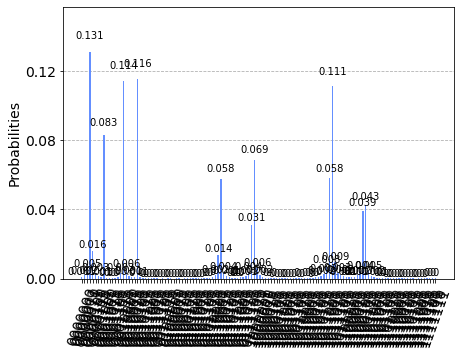

In [71]:
#here s_qubits = 3
#with random_state
from qiskit.quantum_info import random_statevector
gate = qc(hamiltonian3).to_gate().control(1)
tcount = {}
for i in range(10):#for 10 random statevectors
    initial_state2 = random_statevector(8)
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = real, shots = 8192).result()
    count = result.get_counts(qpe2)
    tcount = Counter(tcount)+Counter(count)
display(plot_histogram(tcount))

In [3]:
print(f'Reference value: -2.04567')

Reference value: -2.04567


In [19]:
t = 1
plot_to_eigenval(count,w_qubits,8)

([-1.1780972450961724,
  -3.80427235395639,
  -5.178719139901925,
  -1.521708941582556,
  -1.7671458676442586,
  -3.215223731408304,
  -5.767767762450011,
  -1.5462526341887264],
 [5.105088062083414,
  2.478912953223196,
  1.1044661672776617,
  4.76147636559703,
  4.516039439535327,
  3.067961575771282,
  0.5154175447295755,
  4.73693267299086])

### N=4, JWT, EFT

In [10]:
trotter_number = 1
w_qubits = 10
s_qubits = 4
H4_op = (28.657/trotter_number * I ^ I ^ I^I) + \
        (0.218/trotter_number * Z ^ I ^ I ^ I) - \
        (6.125/trotter_number * I ^ Z ^ I^ I) - \
        (2.143/trotter_number * X ^ X ^ I^I) - \
        (2.143/trotter_number * Y ^ Y ^ I^I) - \
        (9.625/trotter_number * I ^ I ^ Z^I) - \
        (13.125/trotter_number * I ^ I ^ I^Z) - \
        (5.671/trotter_number * I ^ I ^ X^X) - \
        (5.671/trotter_number * I ^I ^ Y^Y) - \
        (3.913/trotter_number * I ^ X ^ X^I) - \
        (3.913/trotter_number * I ^ Y ^ Y^I)
H4 = H4_op.exp_i()
hamiltonian4 = H4.to_matrix()

In [11]:
e,v = np.linalg.eig(H4_op.to_matrix())
v = np.transpose(v)
print(e)

[21.67922136+0.j 39.56288281+0.j 51.24281653+0.j 59.4570793 +0.j
 -2.1430793 +0.j 35.63477864+0.j 17.75111719+0.j  6.07118347+0.j
 53.38589583+0.j 41.70596211+0.j 33.49169934+0.j 23.82230066+0.j
 15.60803789+0.j  3.92810417+0.j  0.        +0.j 57.314     +0.j]


In [ ]:
#with eigenstate
t = 1
initial_state2 = list(v[4])
gate = qc(hamiltonian4).to_gate().control(1)
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
result = execute(qpe2, backend = real, shots = 10000).result()
count = result.get_counts(qpe2)
print(plot_to_eigenval(count,w_qubits,1))
display(qpe2.depth())
print(w_qubits)

## N=4 GC, EFT

In [17]:
trotter_number = 1
w_qubits = 7
s_qubits = 2
H4_GC = (14.328/trotter_number * I ^ I) - \
        (7.814/trotter_number * X ^ I) - \
        (3.913/trotter_number * I ^ X) + \
        (3.913/trotter_number * Z ^ X) - \
        (1.422/trotter_number * Z ^ I) - \
        (8.422/trotter_number * I ^ Z) + \
        (3.527/trotter_number * X ^ Z) - \
        (4.922/trotter_number * Z ^ Z)
GC4 = H4_GC.exp_i()
hamiltonian4_GC = GC4.to_matrix()

In [18]:
e,v = np.linalg.eig(H4_GC.to_matrix())
v = np.transpose(v)
e

array([-2.14539042+0.j,  6.07179357+0.j, 17.75174582+0.j, 35.63385103+0.j])

In [22]:
intial_state = v[0]
gate = qc(hamiltonian4_GC).to_gate().control(1)
w_qubits = 11
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = list(intial_state))
result = execute(qpe2, backend = simulator, shots = 10000).result()
count = result.get_counts(qpe2)
display(plot_to_eigenval(count,w_qubits,1))

KeyboardInterrupt: 

In [20]:
t = 1
plot_to_eigenval(count,w_qubits,1)

([-2.1598449493429825], [4.123340357836604])

# Central Potential 

## JWt N=2

In [10]:
w_qubits = 10
trotter_number = 3
s_qubits = 2
H2_op = (7.858535/trotter_number * I ^ I) + \
        (0.00257/trotter_number * Z ^ I) - \
        (7.861105/trotter_number * I ^ Z) - \
        (0.37778/trotter_number * X ^ X) - \
        (0.37778/trotter_number * Y ^ Y)
H2 = H2_op.exp_i()
hamiltonian2 = H2.to_matrix()

In [86]:
e,v = np.linalg.eig(H2_op.to_matrix())
v = np.transpose(v)
e

array([-0.04135458+0.j, 15.75842458+0.j,  0.        +0.j, 15.71707   +0.j])

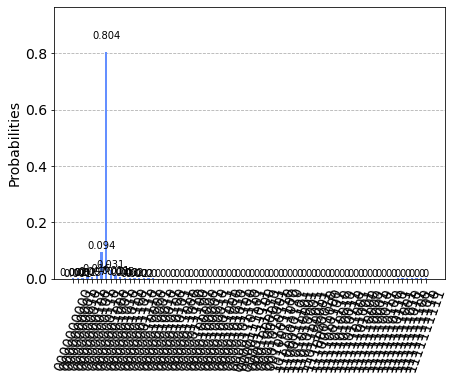

In [88]:
intial_state = v[0]
gate = qc(hamiltonian2).to_gate().control(1)
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = list(intial_state))
result = execute(qpe2, backend = simulator, shots = 10000).result()
count = result.get_counts(qpe2)
display(plot_histogram(count))

In [42]:
t = 1
plot_to_eigenval(count,w_qubits,1)

([-1.5707963267948966], [4.71238898038469])

## JWT, N=3

In [18]:
s_qubits = 3
trotter_number = 1
H3_op = (7.858535/trotter_number * I ^ I ^ I) + \
        (0.00257/trotter_number * Z ^ I^I) - \
        (7.861105/trotter_number * I ^ Z^I) + \
        (15.92676/trotter_number * I ^ I^I) - \
        (15.92676/trotter_number * I ^ I^Z) - \
        (3.6989/trotter_number * X ^ Z^X) - \
        (3.6989/trotter_number * Y ^ Z^Y) + \
        (4.123715/trotter_number * I ^ X^X) + \
        (4.123715/trotter_number * I ^ Y^Y) - \
        (0.37778/trotter_number * X ^ X^I) - \
        (0.37778/trotter_number * Y ^ Y^I)
H3 = H3_op.exp_i()
hamiltonian3 = H3.to_matrix()

In [19]:
e,v = np.linalg.eig(H3_op.to_matrix())
v = np.transpose(v)
e

array([10.86200285+0.j, 34.99957593+0.j, 49.27960122+0.j, 36.70858715+0.j,
       12.57101407+0.j, -1.70901122+0.j,  0.        +0.j, 47.57059   +0.j])

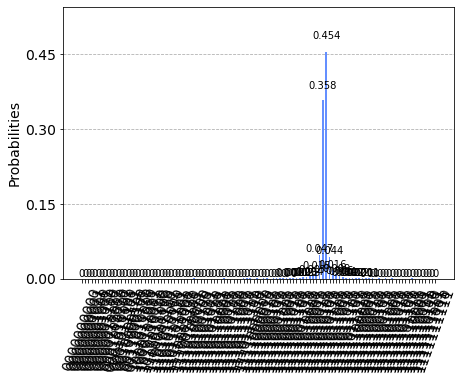

In [20]:
intial_state = v[5]
gate = qc(hamiltonian3).to_gate().control(1)
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = list(intial_state))
result = execute(qpe2, backend = real, shots = 10000).result()
count = result.get_counts(qpe2)
display(plot_histogram(count))

In [26]:
#job = real.retrieve_job("62110d75e206def00c90a47c ")
#count = job.result.get_counts()
#t = 1
#plot_to_eigenval(count,w_qubits,1)
#w_qubits = 10
job  = real.jobs(limit = 2)[1]
count = job.result().get_counts()
plot_to_eigenval(count,w_qubits,1)

([-2.1046216409791], [4.178563666200486])

## N = 4, JWT

In [12]:
H4jwt = (47.48037*I^I^I^I)+(0.00257*Z^I^I^I)-(7.861105*I^Z^I^I)-(15.926755*I^I^Z^I)-\
(23.69503*I^I^I^Z)+(4.123715*I^X^X^I)+(4.123715*I^Y^Y^I)-(2.94793*I^X^I^X)-(2.94793*I^Y^I^Y)+\
(8.51795*I^I^X^X)+(8.851795*I^I^Y^Y)-(0.37778*X^X^I^I)-(0.37778*Y^Y^I^I)-\
(3.6989*X^I^X^I)-(3.6989*Y^I^Y^I)-(2.74671*X^I^I^X)-(2.74671*Y^I^I^Y)
e,v = np.linalg.eig(H4jwt.to_matrix())
v = np.transpose(v)
e

array([-1.43310545e-03+0.j,  6.88164272e+00+0.j,  8.56672694e+01+0.j,
        9.49621970e+01+0.j,  7.44397952e+01+0.j,  5.56375817e+01+0.j,
        2.71332492e+01+0.j,  3.51226578e+01+0.j, -1.73678775e+00+0.j,
        7.91997840e+00+0.j,  9.86942371e+01+0.j,  5.99005252e+01+0.j,
        2.88741515e+01+0.j,  8.19207183e+01+0.j,  6.99602688e+01+0.j,
        3.43098684e+01+0.j])

## Use hybrid Algorithm VQE(to prepare state) + QPE (to get eigenvalue)

In [ ]:
backend = Aer.get_backend('statevector_simulator')

In [ ]:
#state preparation for 2 qubits
theta = 2.5474756255167303
ansatz_1 = QuantumCircuit(2)
ansatz_1.x(0)
ansatz_1.ry(theta, 1)
ansatz_1.cx(1,0)
result = execute(ansatz_1, backend).result()
statevector = result.get_statevector(ansatz_1)

In [ ]:
print(statevector,v[0])

In [ ]:
gate = qc(hamiltonian2).to_gate().control(1)
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = list(statevector))
result = execute(qpe2, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe2)
display(plot_histogram(count))

In [ ]:
t = 1
plot_to_eigenval(count,w_qubits,1)

In [ ]:
#Now with random states
statevector = random_statevector(4).data
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = list(statevector))
result = execute(qpe2, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe2)
display(plot_histogram(count))


In [ ]:
#Random statevector can also work provided the simulation is run many time with a different random statevector  

count_f = {}
#trotter_number = 2
for i in range(20):
    statevector = random_statevector(4).data
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = list(statevector))
    result = execute(qpe2, backend = simulator, shots = 3000).result()
    count = result.get_counts(qpe2)
    count_f = Counter(count) + Counter(count_f)
display(plot_histogram(count_f))

In [ ]:
plot_to_eigenval(count_f,w_qubits,5)

In [67]:
eig = plot_to_eigenval(count,w_qubits,1)
eig[0]

'[-1.5707963267948966]'

In [71]:
# Write the obtained results into a file 
f= open("deuteronH2_data.txt","w+")
for eig in eig_vals:
    f.write("Deuteron Data for 2 qubits, reference value =,", eig "\n")
f.close()


In [72]:
f=open("deuteronH2_data.txt", "a+")
f.write('for initial_state as 1st eigenvector of H2 hamiltonian, eigenvalue = -1.7671458676442586 \n')
f.write('for initial_state as ansatz_1 and theta = -3.7357593954029733(obtained from vqe, we chose other thetas that correspond to correct eigenvalues with vqe to get same answer), eigenvalue = -1.7671458676442586 \n')
f.write('for initial_state as random vector(actually a sum of counts from many(here 20) different random eigenvectors but same setting), eigenvalue = ')
f.write(str(eig[0]))
f.write('\n')
f.close()


## Deuteron Hamiltonian with Gray encoding transformation 

In [10]:
#GC 2 body part (N=2, qubits=1)
trotter_number = 1 #right now
H2_GC = (5.906709/trotter_number * I ) - \
        (6.34329/trotter_number * Z ) - \
        (4.28661/trotter_number * X )
GC2 = H2_GC.exp_i()
hamiltonian2_GC = GC2.to_matrix()

In [11]:
e,v = np.linalg.eig(H2_GC.to_matrix())
v = np.transpose(v)
e

array([-1.74916151+0.j, 13.56257951+0.j])

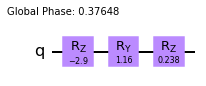

In [16]:
trans = transpile(qc(hamiltonian2_GC),basis_gates = ['x','y','z','h','rx','ry','rz','t'])
trans.draw('mpl')

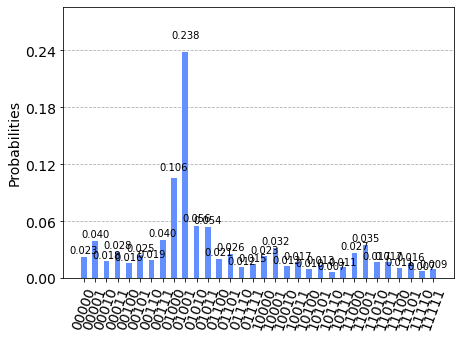

In [15]:
#simulation with noise
t = 1
w_qubits = 5
s_qubits = 1
gate = qc(hamiltonian2_GC).to_gate().control(1)
initial_state2 = list(v[0])
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
result = execute(qpe2, backend = sim_guad, shots = 10000).result()
count = result.get_counts(qpe2)
plot_histogram(count)

In [16]:
plot_to_eigenval(count,w_qubits,1)

([-1.7671458676442586], [4.516039439535327])

# error mitigation using ZNE

In [17]:
from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

## ZNE type1

In [27]:
def ZNErec(circ,n,scale_factors,initial_layout = None):
    #input circ and number of qubits
    #performs the job on required backend for all scaled circuits
    folded_circuits = []
    
    for scale in scale_factors:
        folded_circuits.append(zne.scaling.fold_gates_at_random(circ, scale))
    
    #backend = sim_santiago
    shots= 8192
    job = qiskit.execute(
        experiments=folded_circuits,
        backend=sim_casa,
        optimization_level=0, # Important to preserve folded gatees
        shots=shots,initial_layout = initial_layout)
    all_counts = [job.result().get_counts(k) for k in range(len(folded_circuits))]
    zero_noise_value = []
    
    
    # Performs ZNE for each basis state involved
    numbas= 2**n  #number of basis states
    
    for i in range(numbas):
        
        a = "0" + str(n) + "b"
        i=format(i,a)

        expectation_values = [counts.get(i)/shots
                      for counts in all_counts]

        zero_noise_value.append(zne.ExpFactory.extrapolate(scale_factors, expectation_values, asymptote=0.5))
    
    

    
    # Necessary corrections to add upto 1
    tot= sum(zero_noise_value)
    diff = tot - 1

    corrected_state = [a-diff*(a/tot) for a in zero_noise_value]
    
    # stores in a dict which can be plotted
    
    hist = {}
    for i in range(numbas):
        a = "0" + str(n) + "b"
        k=format(i,a)
        hist[k]=corrected_state[i]
            
    
    return hist

In [63]:
trans_qpe = transpile(qpe2,basis_gates = ['cx','h','rz','rx','x','y'])
scale_factors = [1, 1.5, 2.,2.5,3.]
plot_to_eigenval(ZNErec(trans_qpe,7,scale_factors),w_qubits,1)

([-0.14726215563702155], [6.135923151542564])

## ZNE type 2

In [41]:
USE_REAL_HARDWARE = True

In [42]:
def ibmq_executor(circuit: qiskit.QuantumCircuit, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    if USE_REAL_HARDWARE:
        # Run the circuit on hardware
        job = qiskit.execute(
            experiments=circuit,
            backend=sim_casa,
            #optimization_level=0,  # Important to preserve folded gates.
            shots=shots
        )
    else:
        # Simulate the circuit with noise
        noise_model = initialized_depolarizing_noise(noise_level=0.02)
        job = qiskit.execute(
            experiments=circuit,
            backend=qiskit.Aer.get_backend("qasm_simulator"),
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
        )

    # Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    if counts.get("000") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("000") / shots
    return expectation_value

In [19]:
#JWT 2 qubits
#2 body part
s_qubits = 2
w_qubits = 5
trotter_number = 1
H2_op = (5.906709/trotter_number * I ^ I) + \
        (0.218291/trotter_number * Z ^ I) - \
        (6.125/trotter_number * I ^ Z) - \
        (2.143304/trotter_number * X ^ X) - \
        (2.143304/trotter_number * Y ^ Y)
H2 = H2_op.exp_i()
hamiltonian2 = H2.to_matrix()

In [21]:
e,v = np.linalg.eig(H2_op.to_matrix())
v = np.transpose(v)
e

array([-1.74916122+0.j, 13.56257922+0.j,  0.        +0.j, 11.813418  +0.j])

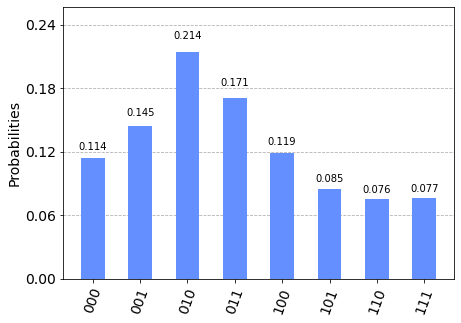

In [36]:
#simulation with noise
t = 1
w_qubits = 3
s_qubits = 2
gate = qc(hamiltonian2).to_gate().control(1)
initial_state2 = list(v[0])
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
result = execute(qpe2, backend = sim_casa, shots = 10000, optimization_level = 3).result()
count = result.get_counts(qpe2)
plot_histogram(count)

In [37]:
plot_to_eigenval(count,w_qubits,1)

([-1.5707963267948966], [4.71238898038469])

/home/tinyrick/anaconda3/envs/qcomp/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


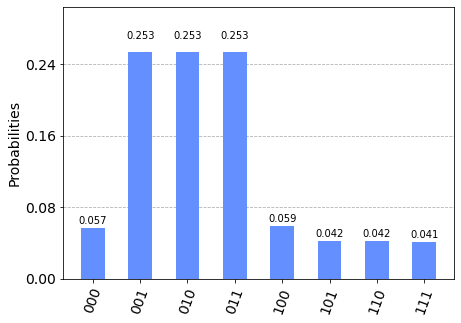

In [40]:
#with mitigation zne
trans_qpe = transpile(qpe2,basis_gates = ['cx','h','rz','rx','x','y'])
scale_factors = [1, 1.5, 2.,2.5,3.]
#initial_layout = [1,5,2,3,4]
ncounts = ZNErec(trans_qpe,3,scale_factors)
plot_histogram(ncounts)
#plot_to_eigenval(ncounts,w_qubits,1)

ZNE is doing something fishy, improving every high peak valued prob. either change mitigation method or find a way that zne extrapolates only 1 peak

In [15]:
#to merge two dictionaries by adding the values for same key
from collections import Counter

In [49]:
random_statevector(2)

Statevector([0.2740676 +0.09794419j, 0.62460735-0.72467893j],
            dims=(2,))


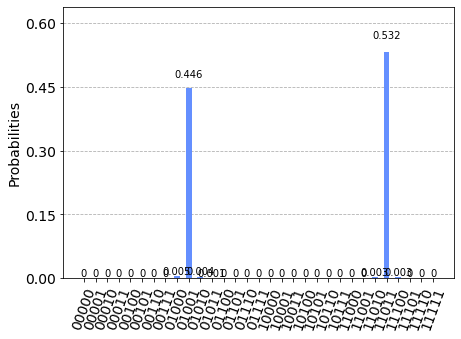

In [51]:
s_qubits = 1
gate = qc(hamiltonian2_GC).to_gate().control(1)
tcount = {}
w_qubits = 5
for i in range(10):#for 10 random statevectors
    initial_state2 = random_statevector(2)
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = simulator, shots = 3000).result()
    count = result.get_counts(qpe2)
    tcount = Counter(tcount)+Counter(count)
display(plot_histogram(tcount))

In [57]:
plot_to_eigenval(tcount,w_qubits,2)

([-5.301437602932776, -1.7671458676442586],
 [0.9817477042468103, 4.516039439535327])

In [23]:
print('trotter_number=2','w_qubits = 5','random_statevector=10')

trotter_number=2 w_qubits = 5 random_statevector=10


In [40]:
# 3 body part (N =3, qubits = 2)
trotter_number = 3
H3_GC = (7.765855/trotter_number * I ^ I) - \
        (7.984145/trotter_number * Z ^ I) - \
        (1.859145/trotter_number * I ^ Z) + \
        (1.640855/trotter_number * Z ^ Z) - \
        (2.143305/trotter_number * X ^ I) - \
        (2.143305/trotter_number * X ^ Z) - \
        (3.91312/trotter_number * I ^ X) + \
        (3.91312/trotter_number * Z ^ X)
GC3 = H3_GC.exp_i()
hamiltonian3_GC = GC3.to_matrix()

In [41]:
e,v = np.linalg.eig(H3_GC.to_matrix())
v = np.transpose(v)

In [42]:
#with eigenstate
s_qubits = 2
initial_state2 = list(v[0])
gate = qc(hamiltonian3_GC).to_gate().control(1)
for w_qubits in range(7,11):
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = simulator, shots = 10000).result()
    count = result.get_counts(qpe2)
    print(plot_to_eigenval(count,w_qubits,1))
    display(qpe2.depth())
    print(w_qubits)

([-2.061670178918302], [4.221515128261284])


384

7
([-2.0371264863121317], [4.246058820867455])


768

8
([-2.0493983326152168], [4.23378697456437])


1536

9
([-2.043262409463674], [4.239922897715912])


3072

10


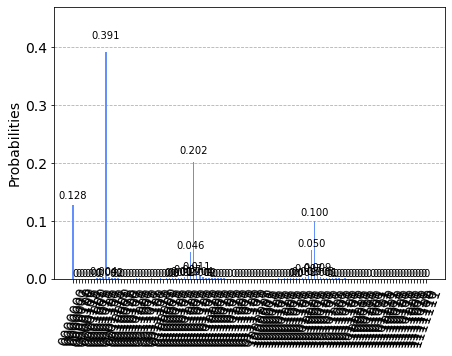

In [68]:
s_qubits = 2
gate = qc(hamiltonian3_GC).to_gate().control(1)
tcount = {}
w_qubits = 7
for i in range(10):#for 10 random statevectors
    initial_state2 = random_statevector(4)
    qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
    result = execute(qpe2, backend = simulator, shots = 3000).result()
    count = result.get_counts(qpe2)
    tcount = Counter(tcount)+Counter(count)
display(plot_histogram(tcount))

In [69]:
plot_to_eigenval(count,w_qubits,4)

([-2.061670178918302, -0.5890486225480862, -2.012582793705961, -0.0],
 [4.221515128261284, 5.6941366846315, 4.270602513473625, 6.283185307179586])

In [16]:
tcount

NameError: name 'tcount' is not defined

# Getting results from backend(hybrid algo)

In [13]:
from qiskit import IBMQ
IBMQ.save_account('efcd8842a5b47fabc0cc7d04db9ff53e7d0180089ee204b47a5d196f77c9101c31e5416ecc161db9d7e7c28dc320a1c4613f74776b7e2bf36810a3bbe8fd9273')
IBMQ.load_account()
IBMQ.providers()

configrc.store_credentials:WARNING:2022-01-09 18:29:49,585: Credentials already present. Set overwrite=True to overwrite.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>]

In [14]:
provider = IBMQ.get_provider(hub = 'ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

NameError: name 'provider' is not defined